## Default estimator and WoE binning (Task 3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv("E:/KAIM 2/KAIM 2 Week 6/Week-6/data/cleaned_credit_data.csv")
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

In [5]:
df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [9]:
# 1. Construct a default estimator (proxy)
# Calculate RFMS features
def calculate_rfms(df):
    # Set the last date of the dataset
    last_date = df['TransactionStartTime'].max()
    
    rfms = df.groupby('CustomerId').agg({
        'TransactionStartTime': lambda x: (last_date - x.max()).days,  # Recency
        'TransactionId': 'count',  # Frequency
        'Amount': 'sum',  # Monetary
        'Value': 'std'  # Standardization (using std of Amount as a simple proxy)
    })
    
    rfms.columns = ['Recency', 'Frequency', 'Monetary', 'Standardization']
    return rfms

rfms = calculate_rfms(df)


In [10]:
print(rfms.shape)  # This will show you the number of rows and columns
print(rfms.columns)  # This will show you the current column names

(3742, 4)
Index(['Recency', 'Frequency', 'Monetary', 'Standardization'], dtype='object')


In [11]:
# Normalize RFMS features
scaler = StandardScaler()
rfms_normalized = pd.DataFrame(scaler.fit_transform(rfms), columns=rfms.columns, index=rfms.index)

In [12]:
# Calculate RFMS score (simple average of normalized features)
rfms_normalized['RFMS_Score'] = rfms_normalized.mean(axis=1)

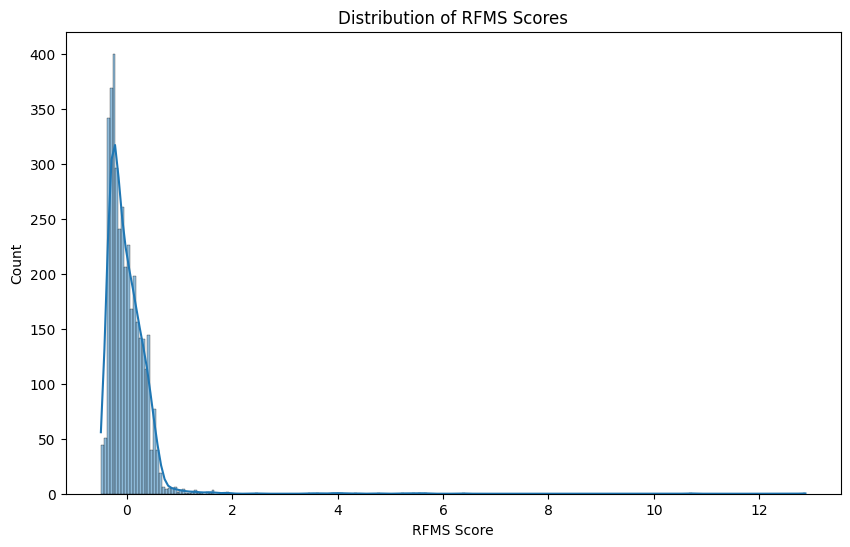

In [13]:
# Visualize RFMS score distribution
plt.figure(figsize=(10, 6))
sns.histplot(rfms_normalized['RFMS_Score'], kde=True)
plt.title('Distribution of RFMS Scores')
plt.xlabel('RFMS Score')
plt.show()

In [14]:
# Define threshold for good/bad classification (e.g., median)
threshold = rfms_normalized['RFMS_Score'].median()
rfms_normalized['Label'] = np.where(rfms_normalized['RFMS_Score'] >= threshold, 'Good', 'Bad')

In [15]:
print("RFMS scores and labels:")
print(rfms_normalized.head())

RFMS scores and labels:
                  Recency  Frequency  Monetary  Standardization  RFMS_Score  \
CustomerId                                                                    
CustomerId_1     1.937605  -0.253459 -0.066891              NaN    0.539085   
CustomerId_10    1.937605  -0.253459 -0.066891              NaN    0.539085   
CustomerId_1001  2.158882  -0.212186 -0.055849        -0.108292    0.445639   
CustomerId_1002 -0.201408  -0.150278 -0.061655        -0.141615   -0.138739   
CustomerId_1003 -0.717722  -0.201868 -0.055849        -0.109732   -0.271293   

                Label  
CustomerId             
CustomerId_1     Good  
CustomerId_10    Good  
CustomerId_1001  Good  
CustomerId_1002   Bad  
CustomerId_1003   Bad  


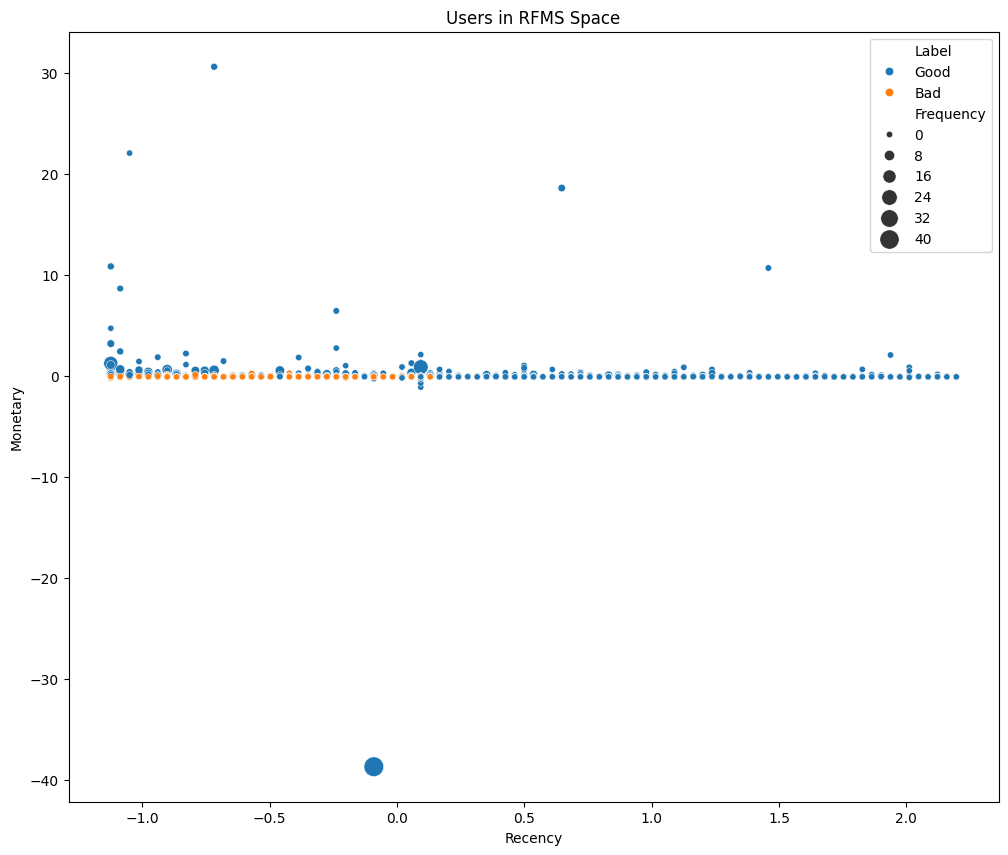

In [16]:
# Visualize users in RFMS space
plt.figure(figsize=(12, 10))
sns.scatterplot(data=rfms_normalized, x='Recency', y='Monetary', hue='Label', size='Frequency', sizes=(20, 200))
plt.title('Users in RFMS Space')
plt.show()

In [17]:
# 2. Perform Weight of Evidence (WoE) binning
def calculate_woe_iv(df, feature, target, bins=10):
    df = df.copy()
    
    if df[feature].dtype == 'O':
        df['bins'] = df[feature]
    else:
        df['bins'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    
    grouped = df.groupby('bins')[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['percent_event'] = grouped['sum'] / grouped['sum'].sum()
    grouped['percent_non_event'] = grouped['non_event'] / grouped['non_event'].sum()
    
    grouped['WoE'] = np.log(grouped['percent_event'] / grouped['percent_non_event'])
    grouped['IV'] = (grouped['percent_event'] - grouped['percent_non_event']) * grouped['WoE']
    
    iv = grouped['IV'].sum()
    
    return grouped, iv


Weight of Evidence for Recency:
                               count       WoE
bins                                          
(-1.1239999999999999, -1.087]    501 -1.505298
(-1.087, -0.976]                 372 -2.203213
(-0.976, -0.865]                 254 -2.171249
(-0.865, -0.607]                 395 -2.830536
(-0.607, -0.238]                 370 -1.788610
(-0.238, 0.131]                  377 -0.207639
(0.131, 0.573]                   385       inf
(0.573, 1.008]                   339       inf
(1.008, 1.606]                   408       inf
(1.606, 2.196]                   341       inf
Information Value: inf


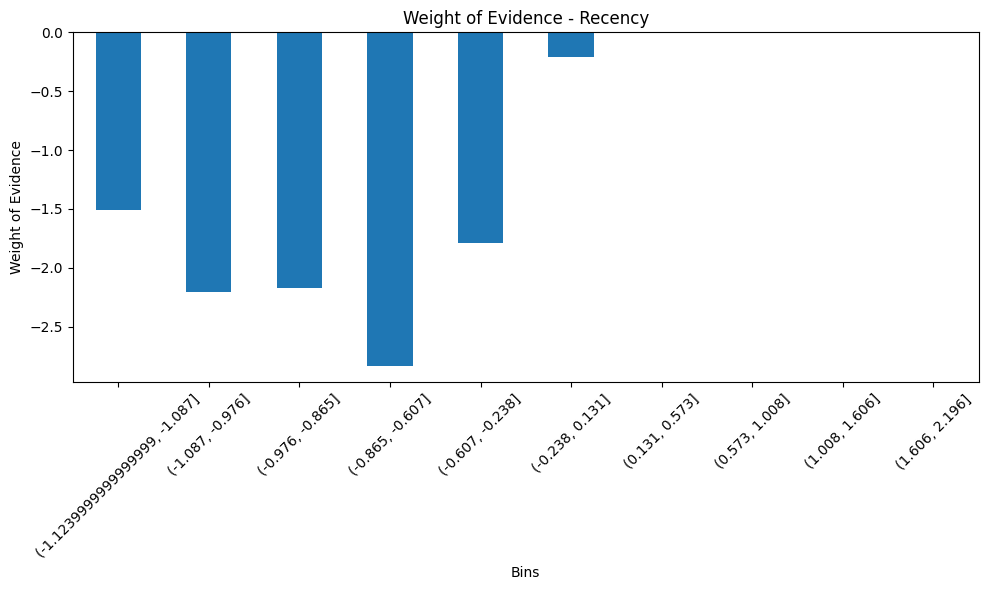


Weight of Evidence for Frequency:
                    count       WoE
bins                               
(-0.254, -0.243]      962  0.715057
(-0.243, -0.233]      222  0.496437
(-0.233, -0.212]      444 -0.108214
(-0.212, -0.192]      368  0.196280
(-0.192, -0.161]      291 -0.325878
(-0.161, -0.0987]     340 -0.467137
(-0.0987, 0.00449]    371 -1.183066
(0.00449, 0.334]      369 -1.003302
(0.334, 41.948]       375  0.529358
Information Value: 0.41697970660465355


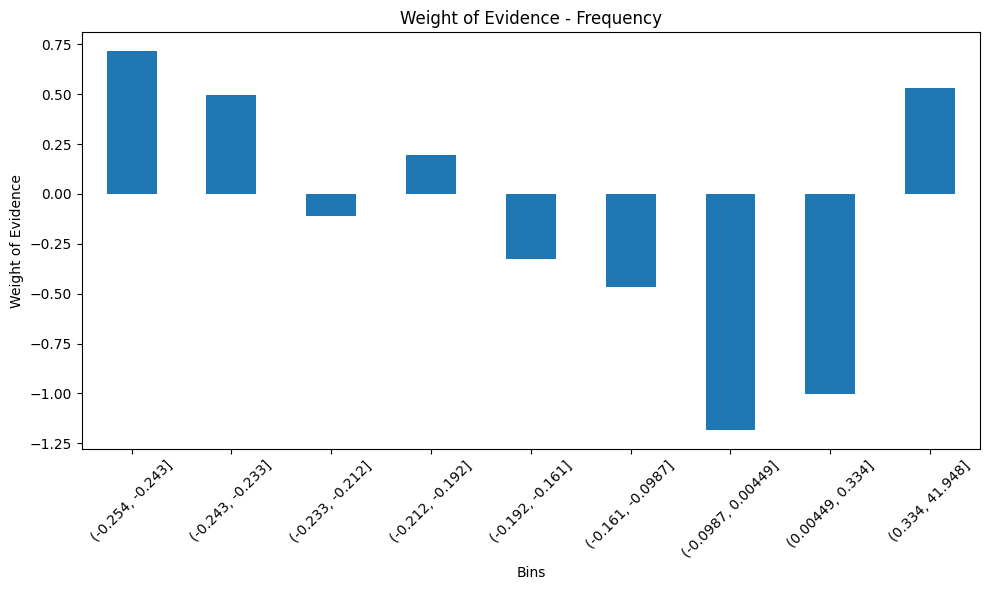


Weight of Evidence for Monetary:
                    count       WoE
bins                               
(-38.674, -0.0629]    377  0.337382
(-0.0629, -0.0625]    408  0.638489
(-0.0625, -0.0607]    338  0.395613
(-0.0607, -0.0581]    374  0.128519
(-0.0581, -0.0558]    440 -0.274437
(-0.0558, -0.0489]    308 -0.261215
(-0.0489, -0.0411]    396 -0.704533
(-0.0411, -0.0263]    352 -0.801714
(-0.0263, 0.0228]     374 -0.536578
(0.0228, 30.652]      375  1.095060
Information Value: 0.3297766917936732


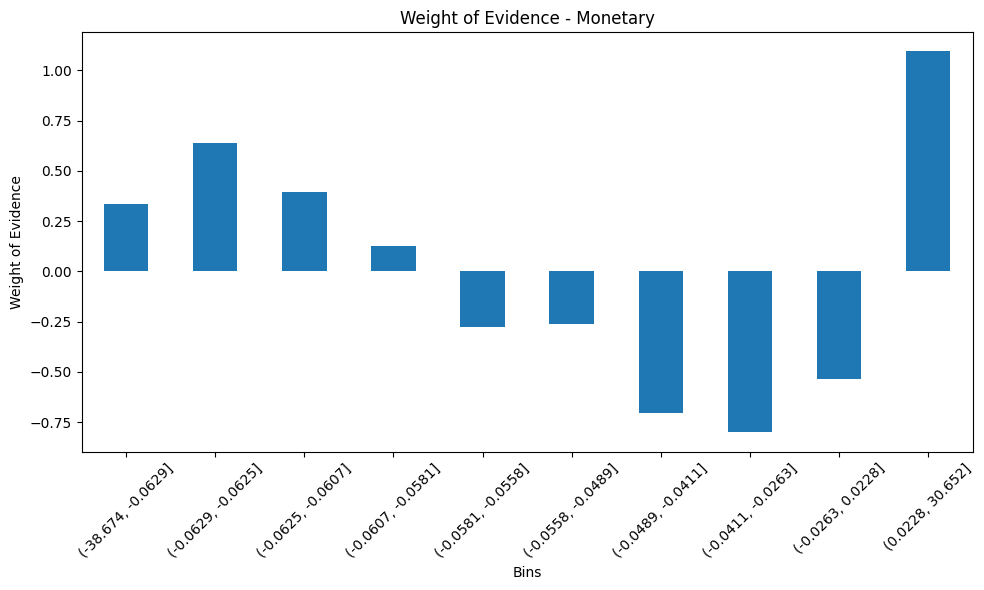


Weight of Evidence for Standardization:
                    count       WoE
bins                               
(-0.147, -0.142]      303  0.665625
(-0.142, -0.138]      303 -0.031930
(-0.138, -0.129]      303 -0.152679
(-0.129, -0.119]      306 -0.305680
(-0.119, -0.114]      301 -0.805578
(-0.114, -0.111]      334 -0.497352
(-0.111, -0.106]      271 -0.266961
(-0.106, -0.0854]     303 -0.005316
(-0.0854, -0.0105]    303  0.127071
(-0.0105, 30.651]     303  1.307697
Information Value: 0.306421467480389


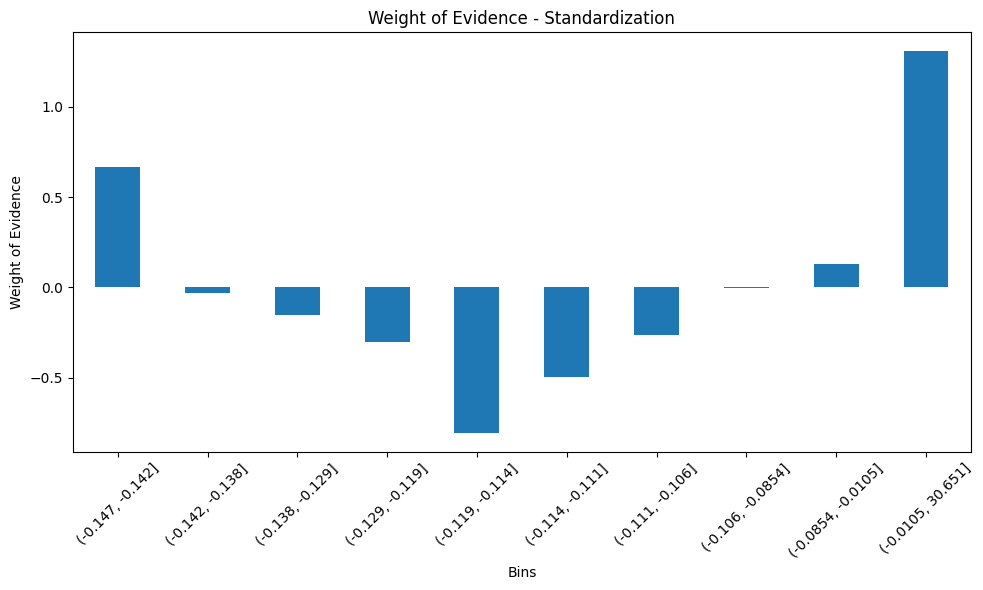

In [18]:
# Perform WoE binning for each RFMS feature
target = 'Label'
rfms_normalized[target] = rfms_normalized[target].map({'Good': 1, 'Bad': 0})

for feature in ['Recency', 'Frequency', 'Monetary', 'Standardization']:
    woe_grouped, iv = calculate_woe_iv(rfms_normalized, feature, target)
    
    print(f"\nWeight of Evidence for {feature}:")
    print(woe_grouped[['count', 'WoE']])
    print(f"Information Value: {iv}")
    
    # Visualize WoE
    plt.figure(figsize=(10, 6))
    woe_grouped['WoE'].plot(kind='bar')
    plt.title(f'Weight of Evidence - {feature}')
    plt.xlabel('Bins')
    plt.ylabel('Weight of Evidence')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Key observations and next steps:

RFMS Classification: The script classifies users as 'Good' or 'Bad' based on their RFMS score. You may need to adjust the threshold based on domain knowledge or business requirements.
Visualization: The scatter plot in RFMS space helps visualize how users are distributed and classified. This can provide insights into the effectiveness of the classification.
WoE Binning: The Weight of Evidence shows how different bins of each feature contribute to distinguishing between 'Good' and 'Bad' customers. Positive WoE indicates higher odds of being a 'Good' customer, while negative WoE indicates higher odds of being a 'Bad' customer.
Information Value (IV): The IV provides a measure of the predictive power of each feature. Generally:
< 0.02: Unpredictive
0.02 to 0.1: Weak
0.1 to 0.3: Medium
0.3: Strong
Feature Selection: Based on the IV values, you can select the most predictive features for your credit scoring model.
Model Development: You can now use these WoE-transformed features to develop your credit scoring model. Logistic Regression is often used with WoE features due to its interpretability.
Validation: Ensure to validate your model on a separate test set and consider using cross-validation for more robust performance estimation.
Monitoring: Once deployed, regularly monitor the model's performance and update it as needed, as the relationships between features and creditworthiness may change over time.